<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC3</p>
<p style="margin: 0; text-align:right;">2021-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats i tractarem d'optimitzar diferents mètriques. Veurem com els diferents models classifiquen els punts i amb quins obtenim major precisió. Després aplicarem tot el que hem après fins ara a un dataset nou simulant un cas pràctic real.

1. Exploració d'algorismes supervisats
       1.2. k veïns més propers
       1.3. Support vector machines
       1.4. Arbre de decisió
       1.5. Random forest
       1.5. Gradient boosting
2. Implementació cas pràctic
       2.1. Anàlisi descriptiu
       2.2. Preprocessament de les dades
       2.3. Entrenament d'un model
       2.4. Predicció de casos nous

**Important: Cadascun dels exercicis pot suposar varios minuts d'execució, pel que l'entrega s'ha de fer en format notebook i en format html on es vegi el codi i els resultats, juntament amb els comentaris de cada exercici. Per a exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nom i cognoms:</strong>
</div>

---

Per a això necessitarem les següents llibreries:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline

## 1. Càrrega de dades

El conjunt de dades MOONS consisteix en punts en un pla que formen dues llunes, d'aquí el nom de "moons". Cada lluna correspon a un grup diferent [0, 1].

El següent codi generara 1.000 punts i en farà un gràfic per visualitzar les dues llunes (amb colors diferents per cada grup).

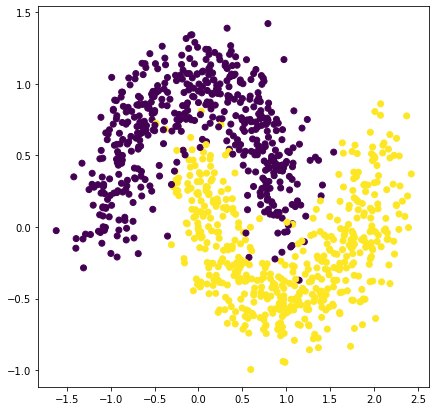

In [2]:
df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Abans d'aplicar cap model, hem de separar les dades entre el conjunt de *train* i el conjunt de *test*. Sempre treballarem sobre el conjunt de *train* i evaluarem els resultats en *test*.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Dividiu el <i>dataset</i> en dos subconjunts, <i>train</i> (80% aprox.) i <i>test</i>. Podeu fer servir l'implementació train_test_split de sklearn.
</div>

Al llarg dels exercicis apendrem a veure gràficament les fronteres de decisió que ens retornen els diferents models. Per fer això utilitzarem la funció definida a continuació. Aquesta segueix els següents passos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) amb els valors mínim i màxim de 'x' i 'y'.
- Predir el classificador amb els valors de la *meshgrid*.
- Fer un *reshape* de les dades per tenir el format corresponent.

Un cop fet això ja podem fer el gràfic de les fronteres de decisió i afegir-hi els punts reals.
Així veurem les àrees que el model considera que són d'una classe i les que considera que són d'una altre. Al posar-hi a sobre els punts veurem si els classifica correctament a l'àrea que els correspon. També veurem les areas d'indecisió, casos en els que el model no es decanta ni cap una classe ni cap una altre (o si que es decanta però no ho té 100% clar), aquestes seran blanquinoses.

In [4]:
# Fem la meshgrid amb els valors màxim i mínim de 'x' i 'y'.
x_min, x_max = df_pd['x'].min()-0.1, df_pd['x'].max()+0.1
y_min, y_max = df_pd['y'].min()-0.1, df_pd['y'].max()+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predim el classifier amb els valors de la meshgrid.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Fem reshape per tenir el format correcte.
    Z = Z.reshape(xx.shape)

    # Seleccionem una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Fem el gràfic de les fronteres de decisió.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Afegim els punts.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.1 $k$ veïns més propers (1 punt)

El primer algoritme que utilitzarem per a classificar els punts és el $k$-nn. En aquest exercici ajustarem dos hiperparàmetres del algoritme per tal d'intentar obtenir una major precisió:

- $k$: el número de veïns que es consideren per a classificar un nou exemple. Provarem amb tots els valors entre 1 i 10.
- pesos: importància que es dona a cadascun dels veïns considerats. En aquest cas provarem amb dues opcions: pesos uniformes, on tots els veïns es consideren igual; i pesos segons distància, on els veïns més propers tenen més pes en la classificació que els veïns més llunyans.

Per a decidir quins són els hiperparàmetres òptims utilitzarem una cerca de reixeta (*grid search*), és a dir, entrenarem un model per a cada combinació de hiperparàmetres possible i l'evaluarem utilitzant validació creuada (*cross validation*) amb 4 particions estratificades. Posteriorment, triarem la combinació d'hiperparàmetres que millors resultats hagi obtingut.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> càlcul del valor òptim dels hiperparàmetres <i>k</i> i <i>pesos</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i KNeighborsClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió. 
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 1.2. Support Vector Machines (1 punt)

En aquest segon exercici classificarem els punts utilitzant l'algoritme SVM amb el *kernel* radial. Tornarem a utilitzar una cerca de reixeta (*grid search*). En aquest cas els hiperparàmetres a optimitzar són:

- C: és la regularització, és a dir, el valor de penalització dels errors en la classificació. Indica el compromís entre obtenir l'hiperpla amb el marge més gran possible i classificar el màxim número d'exemples correctament. Provarem els valors: 0.01, 0.1, 1, 10, 50, 100 i 200.
- gamma: coeficient que multiplica la distància entre dos punts al kernel radial. Per dir-ho a "grosso modo", com més petit és gamma, més influencia tenen dos punts propers. Provarem els valors: 0.001, 0.01, 0.1, 1 i 10.

Igual que en el cas anterior, per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>C</i> i <i>gamma</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòdul GridSearchCV i svm de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 1.3. Arbres de decisió (1 punt)

En aquest tercer exercici classificarem els punts utilitzant un arbre de decisió. Utilitzarem com abans una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres. En aquest cas ajustarem els següents:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 4 i 10. 
- min_samples_split: el mínim nombre d'observacions que ha de tenir una fulla de l'arbre per poder-se dividir. Explorarem els valors: 2, 10, 20, 50 i 100.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>min_samples_split</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i DecisionTreeClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'accuracy i la matriu de confusió.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 1.4. Random forest (1 punt)

En aquest quart punt classificarem els punts utilitzant un Random forest. Utilitzarem, com fins ara, una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres i ajustarem:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 6 i 12. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i RandomForestClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

### 1.5. Gradient boosting (1 punt)

En aquest exercici classificarem els punts utilitzant un Gradient boosting. Utilitzarem com fins ara una cerca de reixeta (*grid search*) per ajustar els següents hiperparàmetres:

- learning_rate: velocitat d'aprenentatge, si el valor és molt alt correm el risc que explori massa i no trobi cap òptim, mentre que si el valor és molt baix pot tardar molt en convergir i estancar-se en un mínim local. Explorarem els valors: 0.01, 0.1, 1 i 2. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>learning_rate</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i GradientBoostingClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

# 2. Implementació cas pràctic (5 punts)

Ara que ja entenem com funcionen alguns models, anem a aplicar-ho a un cas pràctic. El primer exercici s'ha fet amb una variable target categòrica, per aquest exercici en farem servir una de numèrica. És a dir treballarem amb una regressió, no una classificació.

Utilitzarem un conjunt de dades públic de preus de vivendes a Taiwan amb l'objectiu de trobar les millors ofertes del mercat. La descripció completa del conjunt de dades la podem trobar en el següent enllaç:  https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencem carregant les dades en un DataFrame de pandas:

In [25]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") és un identificador numèric de la mostra. Les columnes "*Xn ...*" són els diferents atributs descriptius. Finalment, la columna "*Y ...*" és el valor objetiu o preu de la vivenda.

Extraiem del *DataFrame* la variable objetiu i els atributs descriptius que utilitzarem posteriorment al model predictiu:

In [26]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### 2.1. Anàlisi descriptiu
Quan se'ns proporciona un dataset, abans de començar a fer res, és molt important fer un anàlisi exploratori per coneixer les dades amb les que treballarem.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Analitzar gràficament la distribució de totes les variables (features i target). Recordeu que les variables categòriques es representen amb gràfics de barres, mentres que les numèriques es representen amb histogrames.
</div>

### 2.2. Preprocessament de les dades

Un cop fet un primer anàlisi, es tracta de "netejar" el dataset (les features) i adaptar-lo a les nostres necessitats (en aquest cas, predir el preu d'una vivenda).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Comprova si hi ha null values. En cas d'haver-n'hi, elimina les files corresponents.
</div>

El següent pas seria veure la correlació entre totes les features numèriques. Això es fa per assegurar que no hi han dues variables molt relacionades entre elles, ja que en tal cas seria convenient seleccionar una de les dues o combinar-les en una de nova.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Mostra la correlació entre totes les features numèriques. Si n'hi ha dues amb una correlació superior al 90%, elimina'n una de les dues.
    
Pots utilitzar heatmap, de seaborn, per veure-les en un mapa de colors.
</div>

Ja tenim les variables finals amb les que treballarem. Anem a observar ara quina és la relació de cadascuna de'elles amb el target. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Realitza varis scatterplots creuant els diferents atributs amb la variable target. S'ha de realitzar un scatterplot per atribut.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quins atributs tenen correlació positiva? Quins negativa? Quins no tenen correlació? Analitza cadascun dels gràfics. Té sentit que la relació de l'atribut amb el target sigui aquesta?
</div>

### 2.3. Entrenament d'un model

Ara que ja tenim el dataset net i hem fet un anàlisi de les diferents variables, podem procedir a entrenar un model per tal de predir el preu d'una vivenda. Probarem amb 2 models diferents i n'interpretarem els resultats. Per començar, separem el dataset entre train i test.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Dividiu el <i>dataset</i> en dos subconjunts, <i>train</i> (80% de les dades) i <i>test</i> (20% de les dades). Anomeneu els conjunts: X_train, X_test, y_train, y_test. Utilitzeu l'opció random_state=24.
    
Podeu fer servir l'implementació train_test_split de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Utilitza un arbre de decisió simple amb max_depth=5 per fitar el dataset sobre el conjunt de train. Dibuixa l'arbre de decisió (si et queda molt gran dibuixa'l d'un arbre entrenat amb menys profunditat perquè s'apreci bé). Utilitza alguna mesura d'error (pots escollir la que vulguis: MAE, RMSE, ...) per estimar com de bé ho ha fet el model predint en train i en test. També servirà per poder comparar a posterior amb un altre model.
    
Per dibuixar l'arbre pots guiar-te amb aquest link: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc. Towardsdatascience és un blog que et deixa llegir uns quants articles gratuïtament i després et demana subscripció. Si fos el cas i ja haguessiu arribat al límit, podeu obrir el link amb una pestanya en navegació oculta.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Interpreta l'arbre de decisió, quines són les variables que han tingut més pes? Has obtingut una bona precisió evaluant en test? S'ha produit overfitting?
</div>

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Utilitza Random Forest o Gradient Boosting per fitar el dataset. Aquesta vegada anem a optimitzar el model per obtenir els millors resultats possibles. Tal i com hem vist a l'exercici anterior, recorda seguir els següents passos:
    
  - Utilitzar el dataset de train per trobar els millors hiperparàmetres fent cross-validation.
  - Entrenar el model amb train, predir amb train i test i calcular-ne l'error (MAE, RMSE, ...)
</div>

Un Random Forest / Gradient Boosting no és tant fàcil d'interpretar com un simple Decision Tree. No podem dibuixar l'arbre, perquè són combinacions de molts arbres, però si que podem saber quines han estat les variables més decisives a l'hora de generar el model. Per saber-ho, no podem fer-ho a ull mirant com es divideix l'arbre, sinó que ho podem consultar al model mitjançant la "feature importance" d'aquest.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Mostra cada variable del model fitat, juntament amb la seva feature importance.
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Interpreta el classificador, quines són les variables que han tingut més pes? Has obtingut una bona precisió evaluant en test? S'ha produit overfitting?
</div>

### 2.4. Predicció de casos nous

Fins ara hem entrenat un model i hem evaluat en test per fer-nos una idea de la precisió del nostre model amb dades reals. Ara anem a utilitzar-lo.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> 
    
  - Cas 1: Volem comprar una vivenda que està situada a 1km de l'estació de tren, concretament aquestes són les seves coordenades: 24.87745, 121.31683. La vivenda té 3 botigues properes i es va construir fa 15 anys. Es ven per 24500€/m2, volem saber si està per sobre o per sota el preu de mercat.	
    
  - Cas 2: Som una empresa que es dedica a fer negoci compran pisos barats, arreglant-los i re-venentlos més cars. Volem saber quines vivendes es venen per sota del seu preu de mercat ("chollos") per poder comprar-les i revendre-les en un futur.
</div>